In [1]:
## The imports 
import numpy as np
from PIL import Image 
import cv2
from matplotlib import pyplot as plt


In [2]:
#define Variables
BEACH_PATH = 'Images/Beach.jpg'

In [3]:
#functions
def gaussian_kernel(size, sigma=1): #This function is from towardsdatascience.com
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float16)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float16)
    
    Ix = filter_img(img, Kx, 3)
    Iy = filter_img(img, Ky, 3)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

def non_max_suppression(img, D): #This function is from towardsdatascience.com
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z
        
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09): #This function is from towardsdatascience.com
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255): #This function is from towardsdatascience.com
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

def filter_img(dst_img, KERNEL, FILTER_SIZE): # This function if for filtering the image that we gave to it
    res_img = np.zeros((dst_img.shape[0] - FILTER_SIZE + 1, dst_img.shape[1] - FILTER_SIZE + 1))
    for i in range(dst_img.shape[0] - FILTER_SIZE + 1):
        for j in range(dst_img.shape[1] - FILTER_SIZE + 1):
            res_img[i,j] = np.sum((KERNEL * dst_img[i:i + FILTER_SIZE, j:j + FILTER_SIZE]))
    return res_img

In [5]:
# We need to read the images that are located in our files

Beach_img = cv2.imread(BEACH_PATH, 0) 


In [6]:
g = gaussian_kernel(5)
Beach_img_new = filter_img(Beach_img, g, 5)
Mag, Deg = sobel_filters(Beach_img_new)
new_img = non_max_suppression(Mag, Deg)
res, weak, strong = threshold(new_img)
final = hysteresis(res, weak, strong)

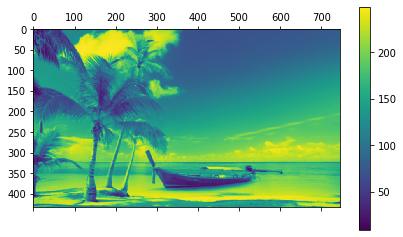

In [10]:
plt.matshow(Beach_img_new);
plt.colorbar()
plt.show()

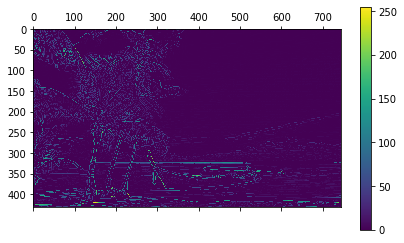

In [9]:
plt.matshow(new_img);
plt.colorbar()
plt.show()

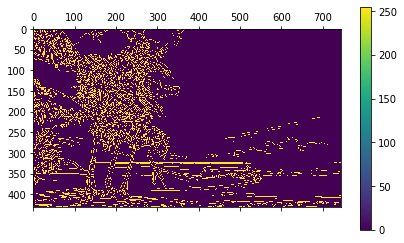

In [7]:
plt.matshow(final);
plt.colorbar()
plt.show()